# Project 2 - Part 1

## TODO

- visualize attention maps: Visualize the attention map learned by your model using input layer weights. Do you gain any insight on important data points to distinguish between normal and abnormal sequences (2 pts)?

- add pooling to CNN in p1 and p2
- better visualization of attention maps
- run all models and finish reporting performance

### Part 2 
- add pooling to autoencoder
- improve UMAP projections
- Run finetuning strategies when everything is correct


In [3]:
pip install -r requirements.txt

ERROR: Ignored the following versions that require a different python version: 8.19.0 Requires-Python >=3.10; 8.20.0 Requires-Python >=3.10; 8.21.0 Requires-Python >=3.10; 8.22.0 Requires-Python >=3.10; 8.22.1 Requires-Python >=3.10; 8.22.2 Requires-Python >=3.10; 8.23.0 Requires-Python >=3.10; 8.24.0 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement ipython==8.24.0 (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import math
import pickle
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

## Exploratory Data Analysis

In [2]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']

X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

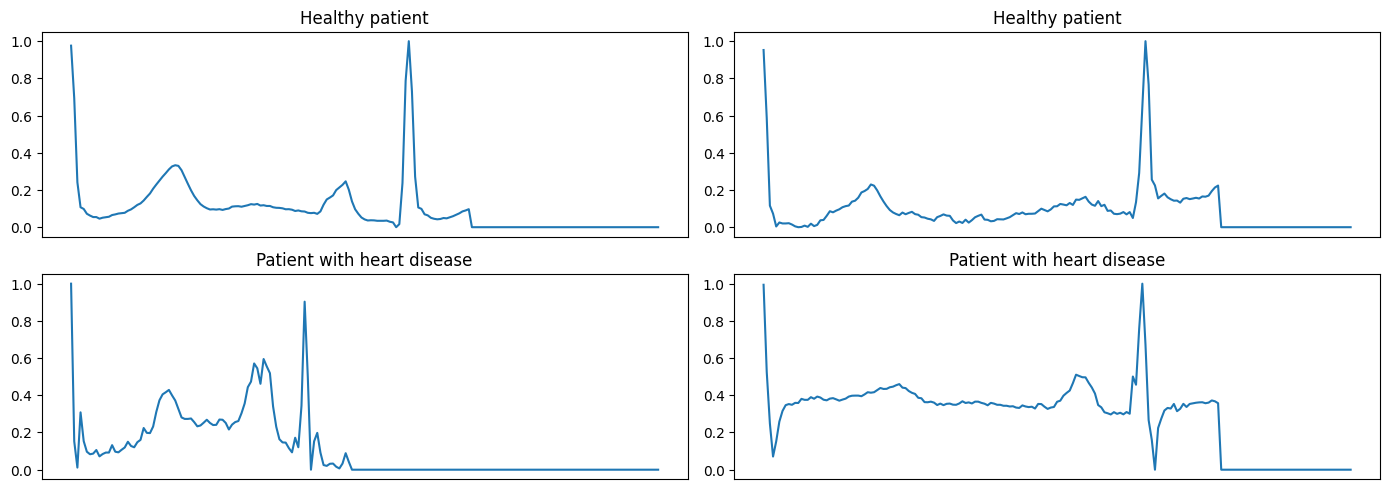

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

# Flatten the array for easy iteration
axs = axs.flatten()

healthy_patients = X_train.loc[y_train == 0]
diagnosed_patients = X_train.loc[y_train == 1]

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    if i < 2:
        axs[i].plot(healthy_patients.iloc[i % 2])
        axs[i].set_title('Healthy patient')
    else:
        axs[i].plot(diagnosed_patients.iloc[i % 2])
        axs[i].set_title('Patient with heart disease')
    
    # Set x ticks in 3 equidistant positions
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

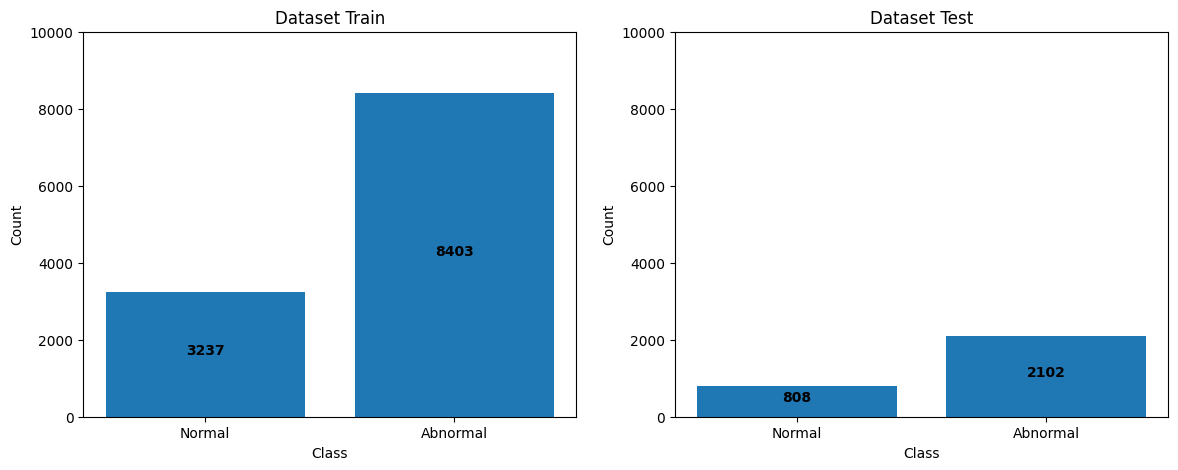

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(['Normal', 'Abnormal'], datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
    axs[i].set_ylim((0,10000))
plt.show()


In [103]:
n = len(y_train) + len(y_test)
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(len(datasets[i])/n*100) + '%')

Dataset Train: 80.0%
Dataset Test: 20.0%


In [104]:
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(np.mean(datasets[i])*100) + '%')

Dataset Train: 72.19072164948453%
Dataset Test: 72.23367697594502%


## Classic Machine Learning Methods

### Logistic Regression

In [3]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Train accuracy: ' + str(log_reg.score(X_train, y_train)))
print('Test accuracy: ' + str(log_reg.score(X_test, y_test)))

print(f'Training balanced accuracy: {balanced_accuracy_score(y_train, log_reg.predict(X_train))}')
print(f'Test balanced accuracy: {balanced_accuracy_score(y_test, log_reg.predict(X_test))}')

Train accuracy: 0.8344501718213059
Test accuracy: 0.8223367697594501
Training balanced accuracy: 0.763882873376901
Test balanced accuracy: 0.747882144303869


### Random Forest

In [4]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Train accuracy: ' + str(rf.score(X_train, y_train)))
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

print(f'Training balanced accuracy: {balanced_accuracy_score(y_train, rf.predict(X_train))}')
print(f'Test balanced accuracy: {balanced_accuracy_score(y_test, rf.predict(X_test))}')

Train accuracy: 1.0
Test accuracy: 0.9666666666666667
Training balanced accuracy: 1.0
Test balanced accuracy: 0.9498797703271755


### Feature Design

In [17]:
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

X_train_no_zeros = X_train[X_train > 0]
X_test_no_zeros = X_test[X_test > 0]

X_train_extended['mean'] = X_train_no_zeros.mean(axis=1)
X_train_extended['std'] = X_train_no_zeros.std(axis=1)
X_train_extended['median'] = X_train_no_zeros.median(axis=1)
X_train_extended['max'] = X_train_no_zeros.max(axis=1)
X_train_extended['min'] = X_train_no_zeros.min(axis=1)
X_train_extended['range'] = X_train_no_zeros.max(axis=1) - X_train_no_zeros.min(axis=1)
X_train_extended['iqr'] = X_train_no_zeros.quantile(0.75, axis=1) - X_train_no_zeros.quantile(0.25, axis=1)
X_train_extended['q1'] = X_train_no_zeros.quantile(0.25, axis=1)
X_train_extended['q3'] = X_train_no_zeros.quantile(0.75, axis=1)
X_train_extended['kurtosis'] = X_train_no_zeros.kurtosis(axis=1)
X_train_extended['skew'] = X_train_no_zeros.skew(axis=1)
X_test_extended['mean'] = X_test_no_zeros.mean(axis=1)
X_test_extended['std'] = X_test_no_zeros.std(axis=1)
X_test_extended['median'] = X_test_no_zeros.median(axis=1)
X_test_extended['max'] = X_test_no_zeros.max(axis=1)
X_test_extended['min'] = X_test_no_zeros.min(axis=1)
X_test_extended['range'] = X_test_no_zeros.max(axis=1) - X_test_no_zeros.min(axis=1)
X_test_extended['iqr'] = X_test_no_zeros.quantile(0.75, axis=1) - X_test_no_zeros.quantile(0.25, axis=1)
X_test_extended['q1'] = X_test_no_zeros.quantile(0.25, axis=1)
X_test_extended['q3'] = X_test_no_zeros.quantile(0.75, axis=1)
X_test_extended['kurtosis'] = X_test_no_zeros.kurtosis(axis=1)
X_test_extended['skew'] = X_test_no_zeros.skew(axis=1)

In [18]:
log_reg_extended = LogisticRegression(max_iter=1000)
log_reg_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(log_reg_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(log_reg_extended.score(X_test_extended, y_test)))

print(f'Training balanced accuracy: {balanced_accuracy_score(y_train, log_reg_extended.predict(X_train_extended))}')
print(f'Test balanced accuracy: {balanced_accuracy_score(y_test, log_reg_extended.predict(X_test_extended))}')

Train accuracy: 0.8577319587628865
Test accuracy: 0.8515463917525773
Training balanced accuracy: 0.801849200553622
Test balanced accuracy: 0.7943860632495219


In [19]:
rf_extended = RandomForestClassifier()
rf_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(rf_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(rf_extended.score(X_test_extended, y_test)))

print(f'Training balanced accuracy: {balanced_accuracy_score(y_train, rf_extended.predict(X_train_extended))}')
print(f'Test balanced accuracy: {balanced_accuracy_score(y_test, rf_extended.predict(X_test_extended))}')

Train accuracy: 1.0
Test accuracy: 0.9725085910652921
Training balanced accuracy: 1.0
Test balanced accuracy: 0.9581139131991221


## Recurrent Neural Networks - LSTM

### Unidirectional LSTM


In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [4]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Shuffle training data
np.random.seed(42)
shuffling_indices = np.random.permutation(len(X_train_tensor))
X_train_tensor = X_train_tensor[shuffling_indices]
y_train_tensor = y_train_tensor[shuffling_indices]

# Balance training data
X_train_tensor = torch.cat([X_train_tensor[y_train == 0], X_train_tensor[y_train == 1][:len(y_train[y_train == 0])]])
y_train_tensor = torch.cat([y_train_tensor[y_train == 0], y_train_tensor[y_train == 1][:len(y_train[y_train == 0])]])

X_train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=100, shuffle=True)
X_test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=100, shuffle=False)

In [39]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []
    
    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        true_train = []
        pred_train = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]
            
            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)
                
            loss = criterion(outputs, y_batch)
            pred_train.append((outputs > 0.5).int())
            true_train.append(y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        epoch_accuracies_training.append(balanced_accuracy_score(torch.cat(true_train).int().cpu().numpy(), torch.cat(pred_train).cpu().numpy()))
        epoch_losses_training.append(total_loss/len(X_train_tensor))

        with torch.no_grad():
            pred_test = []
            true_test = []
            total_loss_test = 0
            for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
                if truncate:
                    max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                    X_batch = X_batch[:, :max_seq_len, :]
                
                if ret_weights:
                    outputs, _ = model(X_batch)
                else:
                    outputs = model(X_batch)
                    
                loss = criterion(outputs, y_batch)
                pred_test.append((outputs > 0.5).int())
                true_test.append(y_batch)

                total_loss_test += loss.item() * len(X_batch)

            epoch_accuracies_testing.append(balanced_accuracy_score(torch.cat(true_test).int().cpu().numpy(), torch.cat(pred_test).cpu().numpy()))
            epoch_losses_testing.append(total_loss_test/len(X_test_tensor))

            pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')
        
    with open(f'./p1/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
        pickle.dump((epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing), f)

    torch.save(model.state_dict(), f'./p1/models/{model_name}_{num_epochs}.pth')

In [40]:
def plot_acc_and_loss(model_name, num_epochs):
    
    with open(f'./p1/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(f)
            except EOFError:
                break

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plotting the losses
    axs[0].plot(epoch_losses_training, label='Training Loss')
    axs[0].plot(epoch_losses_testing, label='Testing Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plotting the accuracies
    axs[1].plot(epoch_accuracies_training, label='Training Balanced Accuracy')
    axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
def print_model_summary(model, criterion, X_test_dataloader, ret_weights=False, truncate=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    with torch.no_grad():
        pred_test = []
        true_test = []
        total_loss_test = 0
        for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]
            
            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)
                
            loss = criterion(outputs, y_batch)
            pred_test.append((outputs > 0.5).int())
            true_test.append(y_batch)

            total_loss_test += loss.item() * len(X_batch)

        test_balanced_acc = balanced_accuracy_score(torch.cat(true_test).int().cpu().numpy(), torch.cat(pred_test).cpu().numpy())
        test_loss = (total_loss_test/len(X_test_tensor))

        print(f'Test set Balanced Accuracy: {test_balanced_acc:.4f}, Test set Loss: {test_loss:.4f}')

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=True, bidirectional=bidirectional)
        
        _hidden_size = hidden_size if not bidirectional else hidden_size * 2
        self.fc1 = torch.nn.Linear(_hidden_size * num_layers, hidden_size * num_layers)
        self.fc2 = torch.nn.Linear(hidden_size * num_layers, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                # Initialize weights with Xavier initialization
                init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zeros
                init.constant_(param, 0.0)
        
    def forward(self, x):
        _, (hidden,_) = self.lstm(x)
        out = self.fc1(hidden.permute(1,0,2).flatten(start_dim=1))
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [28]:
input_size = 1  
hidden_size = 50
num_layers = 5
output_size = 1

lstm = LSTMModel(input_size, hidden_size, num_layers, output_size, bidirectional=False).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0005)

In [29]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'lstm'

In [ ]:
train_model(lstm, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=True)

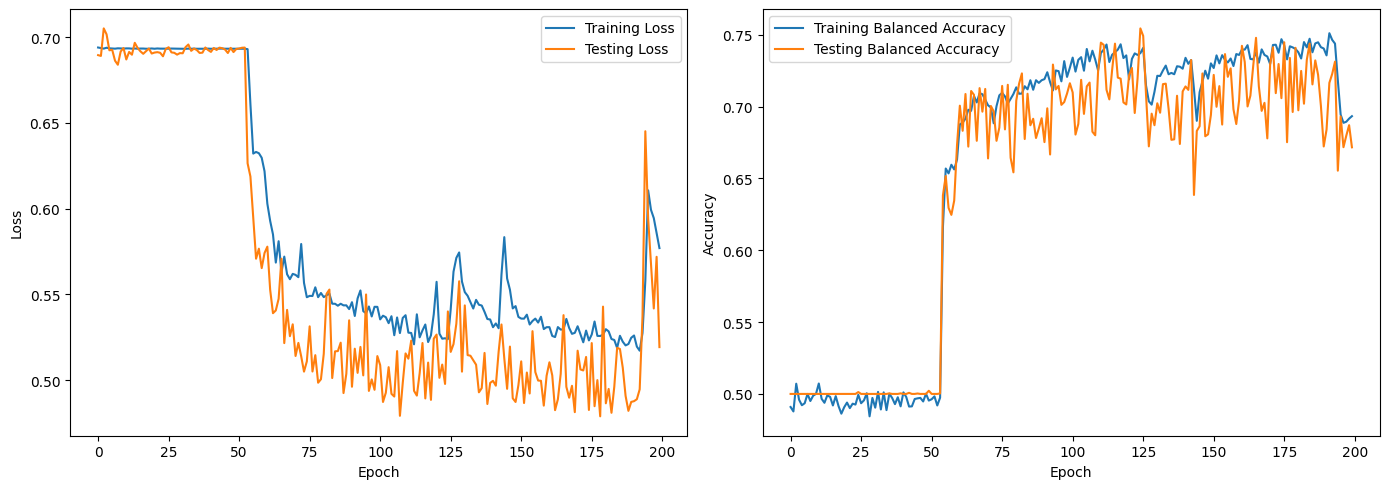

In [15]:
plot_acc_and_loss(model_name, num_epochs)

In [30]:
lstm.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(lstm, criterion, X_test_dataloader, truncate = True)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=250, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 155201
Test set Balanced Accuracy: 0.7266, Test set Loss: 0.5831


### Bidirectional LSTM


In [21]:
lstm_bidir = LSTMModel(input_size, hidden_size, num_layers, output_size, bidirectional=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_bidir.parameters(), lr=0.0005)

In [22]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'lstm_bidir'

Epoch [200/200], Loss: 0.0185, Balanced Accuracy: 0.9922, Test Loss: 0.1906, Test Balanced Accuracy: 0.9809: 100%|██████████| 200/200 [36:08<00:00, 10.84s/it]


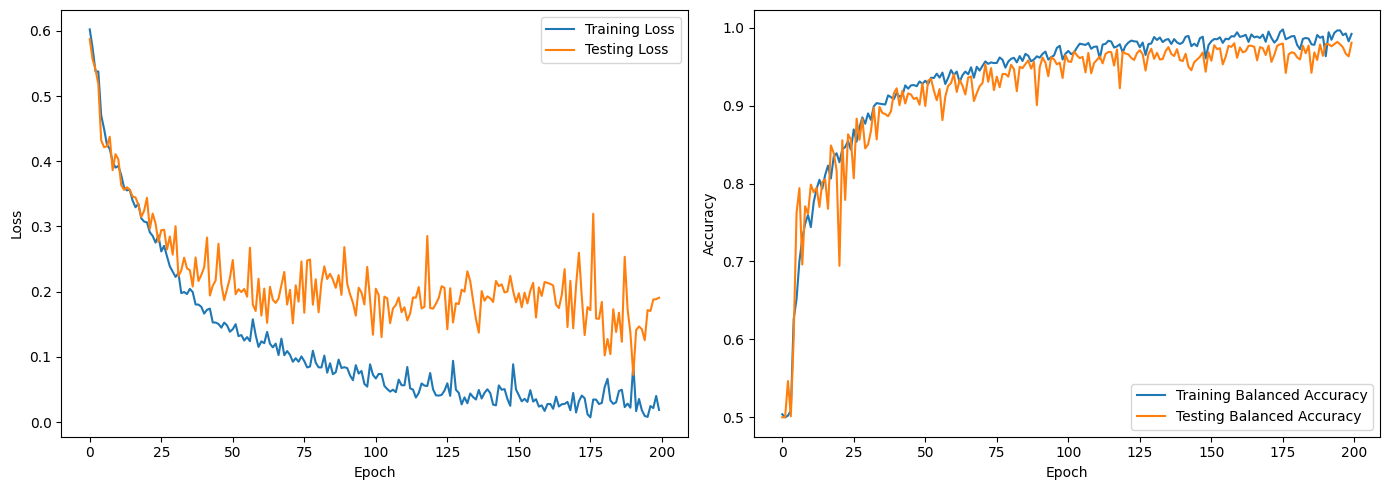

In [65]:
train_model(lstm_bidir, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=True)
plot_acc_and_loss(model_name, num_epochs)

In [25]:
lstm_bidir.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(lstm_bidir, criterion, X_test_dataloader, truncate = True)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=5, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=500, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 389901
Test set Balanced Accuracy: 0.9809, Test set Loss: 0.1906


## Convolutional Neural Networks

### Vanilla CNN

In [26]:
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.fc = nn.LazyLinear(out_features = output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.squeeze(x, dim=-1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [34]:
input_size = X_train_tensor.shape[1]
output_size = 1

cnn = CNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0005)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [35]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'cnn'

Epoch [200/200], Loss: 0.1097, Balanced Accuracy: 0.9542, Test Loss: 0.1976, Test Balanced Accuracy: 0.9134: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


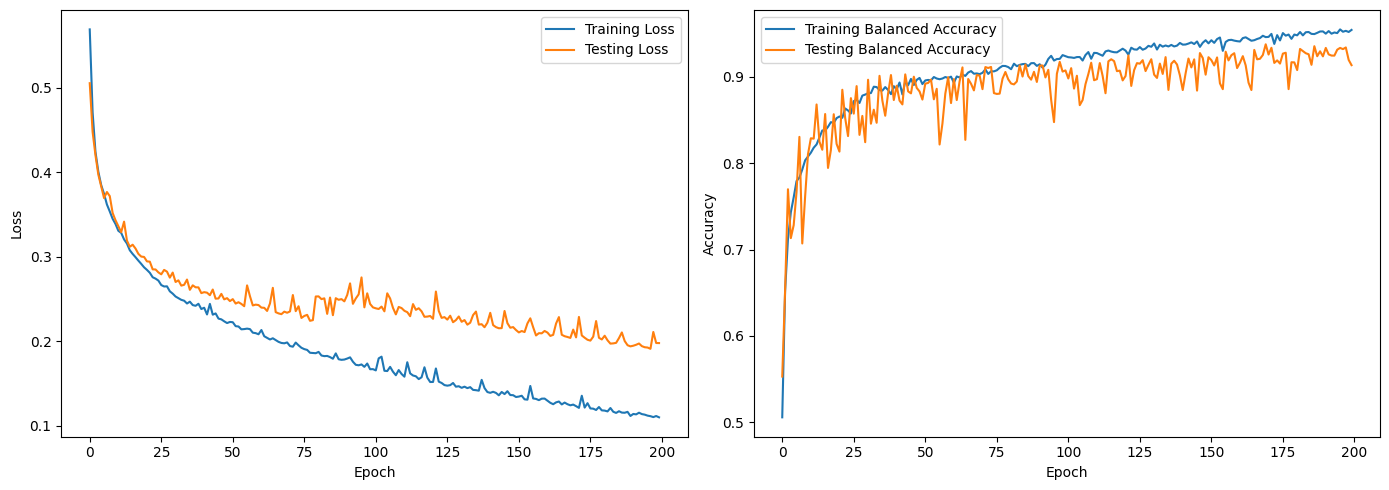

In [123]:
train_model(cnn, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=False)
plot_acc_and_loss(model_name, num_epochs)

In [36]:
cnn.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(cnn, criterion, X_test_dataloader)

CNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 3105
Test set Balanced Accuracy: 0.9134, Test set Loss: 0.1976


### CNN with residual connections

In [37]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        x = self.relu(x)
        return x

In [38]:
class ResidualCNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2)

        self.residual_block1 = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2 = ResidualBlock(16, 16, 3, 1, 1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2 = nn.MaxPool1d(kernel_size=3, stride=2)

        self.fc = nn.LazyLinear(output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = torch.squeeze(x, dim=-1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [39]:
input_size = X_train_tensor.shape[1]
output_size = 1

cnn_res = ResidualCNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_res.parameters(), lr=0.0005)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [40]:
num_epochs = 200
torch.manual_seed(42)
model_name = 'cnn_res'

Epoch [200/200], Loss: 0.0694, Balanced Accuracy: 0.9675, Test Loss: 0.1409, Test Balanced Accuracy: 0.9467: 100%|██████████| 200/200 [02:57<00:00,  1.13it/s]


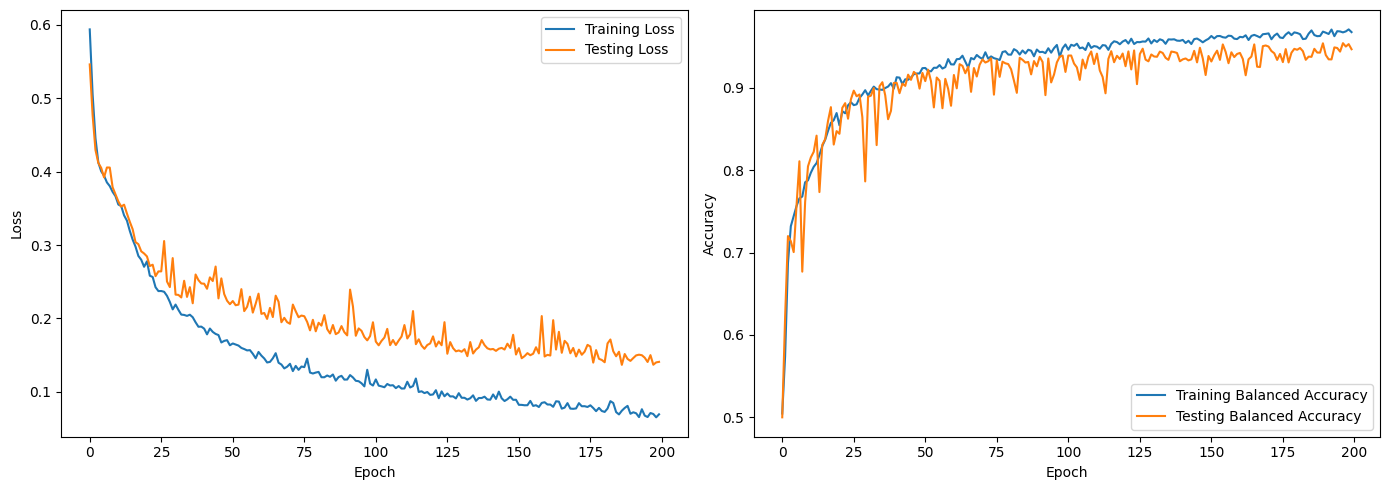

In [137]:
train_model(cnn_res, model_name, criterion, optimizer, X_train_dataloader, X_test_dataloader, num_epochs=num_epochs, truncate=False)
plot_acc_and_loss(model_name, num_epochs)

In [42]:
cnn_res.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(cnn_res, criterion, X_test_dataloader)

ResidualCNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block1): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
  )
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)
Number of parameters: 6241
Test set Balanced Accuracy: 0.9467, Test set Loss: 0.1409


## Attention and Transformers

In [6]:
# These tensors are padded by one dimension to make dimension be a factor of 4

X_train_tensor_transformer = torch.nn.functional.pad(input=X_train_tensor, pad=(0, 0, 0, 1, 0, 0), mode='constant', value=0)
X_train_tensor_transformer = X_train_tensor_transformer.view(len(X_train_tensor_transformer), -1, 4)

X_test_tensor_transformer = torch.nn.functional.pad(input=X_test_tensor, pad=(0, 0, 0, 1, 0, 0), mode='constant', value=0)
X_test_tensor_transformer = X_test_tensor_transformer.view(len(X_test_tensor_transformer), -1, 4)

train_dataloader_transformer = DataLoader(torch.utils.data.TensorDataset(X_train_tensor_transformer, y_train_tensor), batch_size=100, shuffle=True)
test_dataloader_transformer = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_transformer, y_test_tensor), batch_size=100, shuffle=False)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(5000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [47]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_size, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first = True, norm_first=False, activation="relu")
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.sigmoid = nn.Sigmoid()
        self.d_model = d_model

    def embed(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        return src
        
    def forward(self, src):
        src = self.embed(src)
        output = self.transformer_encoder(src)
        output = self.fc(output.mean(dim=1))  # Global average pooling
        output = self.sigmoid(output)
        
        attention_weights = self.transformer_encoder.layers[0].self_attn.in_proj_weight
        first_layer_weights = self.embedding.weight
        
        return output, (attention_weights, first_layer_weights)

In [64]:
input_size = X_train_tensor_transformer.shape[2]
output_size = 1

transformer = TransformerModel(input_size, output_size, d_model=16).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

num_epochs = 200
torch.manual_seed(42)
model_name = 'transformer'

Epoch [199/199], Loss: 0.1595, Balanced Accuracy: 0.9113, Test Loss: 0.1909, Test Balanced Accuracy: 0.9022: 100%|██████████| 199/199 [07:03<00:00,  2.13s/it]


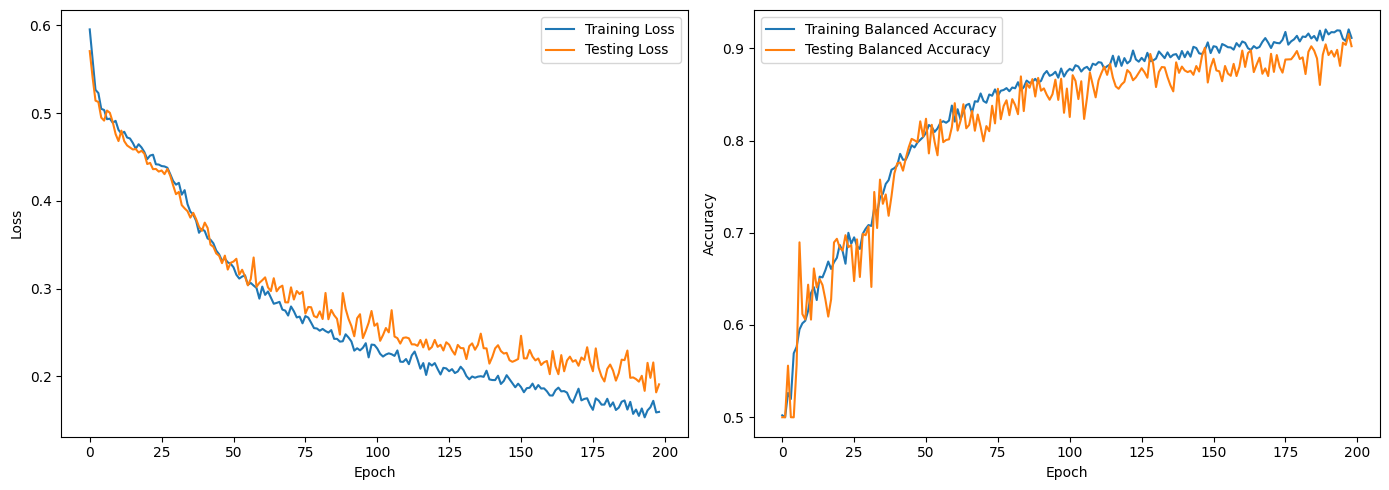

In [57]:
train_model(transformer, model_name, criterion, optimizer, train_dataloader_transformer, test_dataloader_transformer, num_epochs=num_epochs, truncate=True, ret_weights=True)
plot_acc_and_loss(model_name, num_epochs)

In [65]:
transformer = TransformerModel(input_size, output_size, d_model=16).to(device)

transformer.load_state_dict(torch.load(f'./p1/models/{model_name}_{num_epochs}.pth'))
print_model_summary(transformer, criterion, test_dataloader_transformer, ret_weights=True)

TransformerModel(
  (embedding): Linear(in_features=4, out_features=16, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters: 54289
Test set 

In [60]:
def compute_selfattention(transformer_encoder, x, i_layer, d_model, num_heads):
    h = torch.nn.functional.linear(x, transformer_encoder.layers[i_layer].self_attn.in_proj_weight, bias=transformer_encoder.layers[i_layer].self_attn.in_proj_bias)
    qkv = h.reshape(x.shape[0], x.shape[1], num_heads, 3 * d_model//num_heads)
    qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
    q, k, v = qkv.chunk(3, dim=-1) # [Batch, Head, SeqLen, d_head=d_model//num_heads]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [Batch, Head, SeqLen, SeqLen]
    d_k = q.size()[-1]
    attn_probs = attn_logits / math.sqrt(d_k)
    
    attn_probs = torch.nn.functional.softmax(attn_probs, dim=-1)
    return attn_logits,attn_probs

def extract_selfattention_maps(transformer_encoder, x):
    attn_logits_maps = []
    attn_probs_maps = []
    num_layers = transformer_encoder.num_layers
    d_model = transformer_encoder.layers[0].self_attn.embed_dim
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            # attn = transformer_encoder.layers[i].self_attn(h, h, h,attn_mask=mask,key_padding_mask=src_key_padding_mask,need_weights=True)[1]
            # attention_maps.append(attn) # of shape [batch_size,seq_len,seq_len]
            attn_logits,attn_probs = compute_selfattention(transformer_encoder,h,i,d_model,num_heads)
            attn_logits_maps.append(attn_logits) # of shape [batch_size,num_heads,seq_len,seq_len]
            attn_probs_maps.append(attn_probs)
            # forward of layer i
            x = transformer_encoder.layers[i](x,src_mask=None,src_key_padding_mask=None)
    return attn_logits_maps,attn_probs_maps

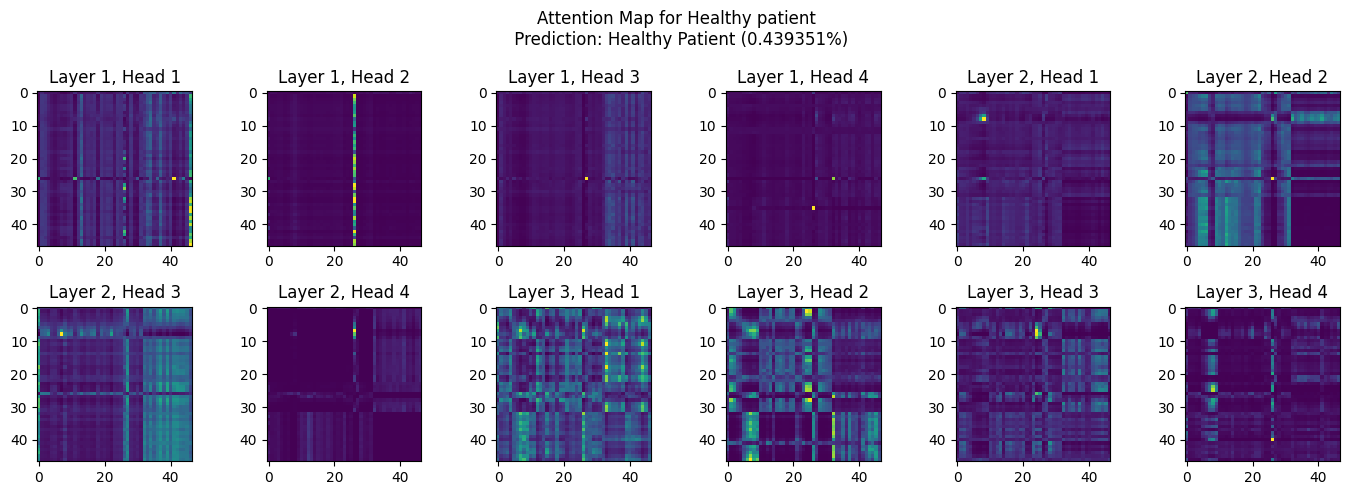

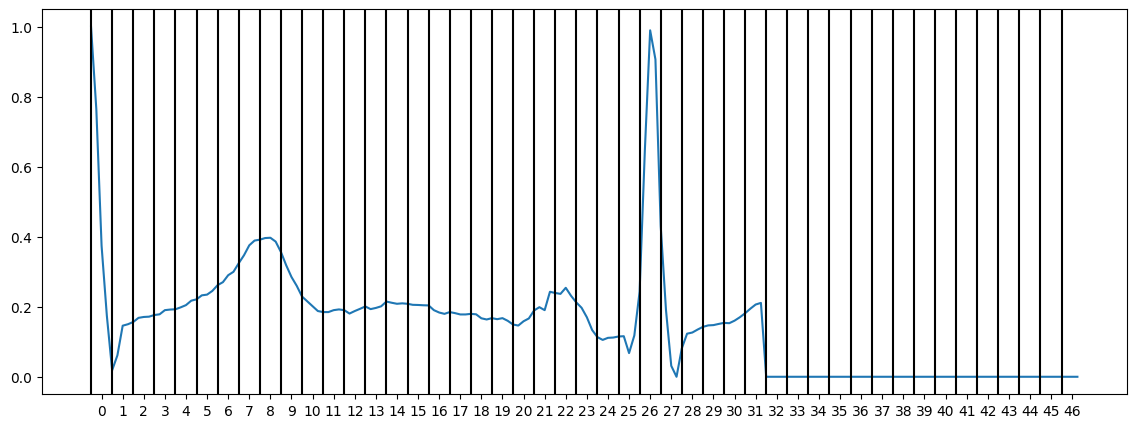

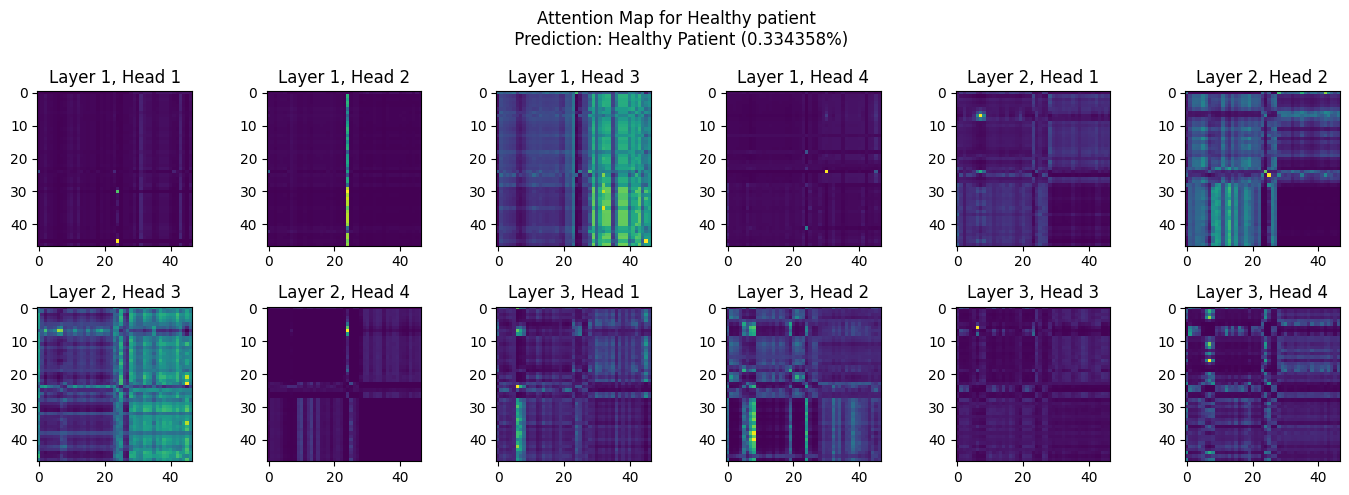

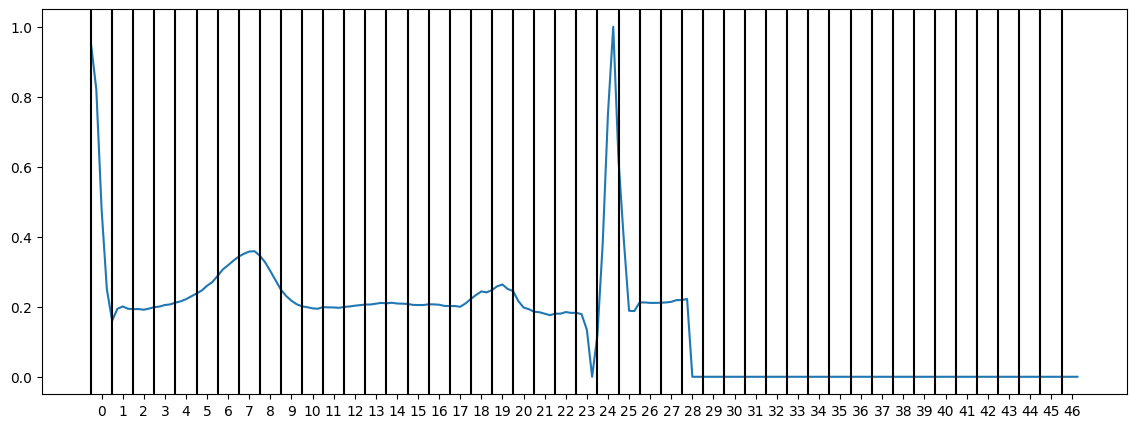

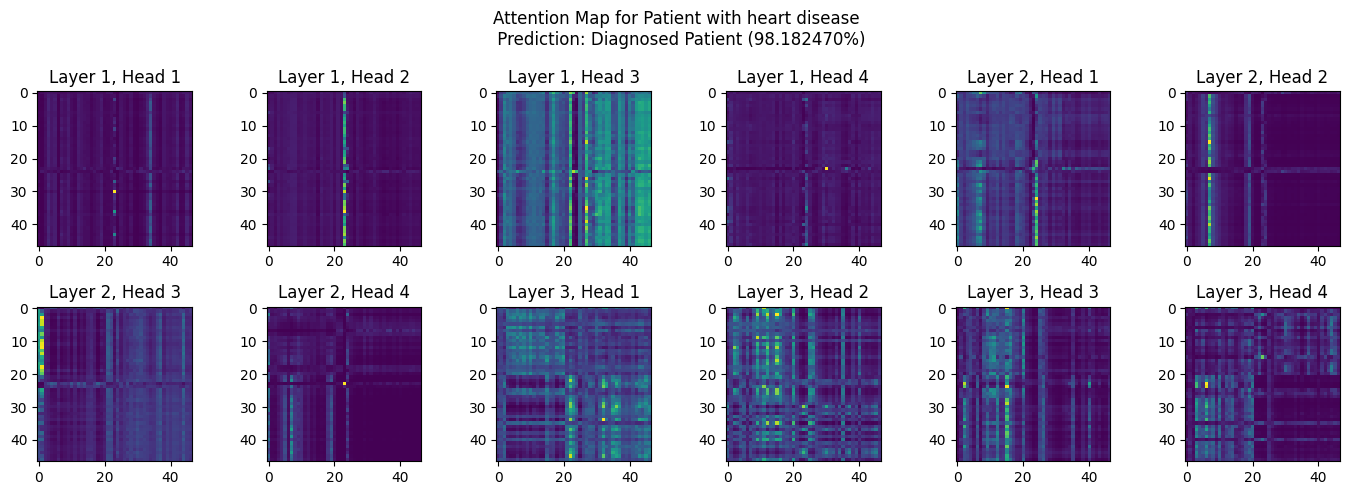

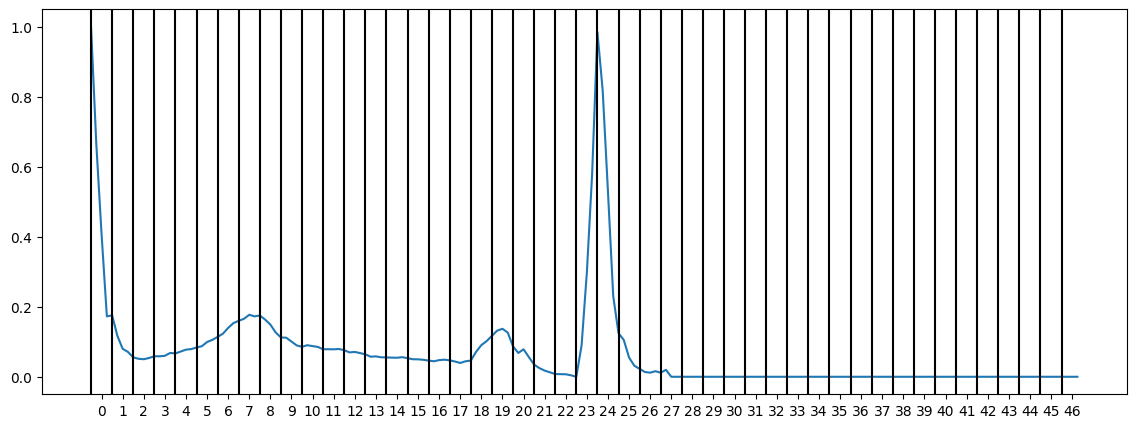

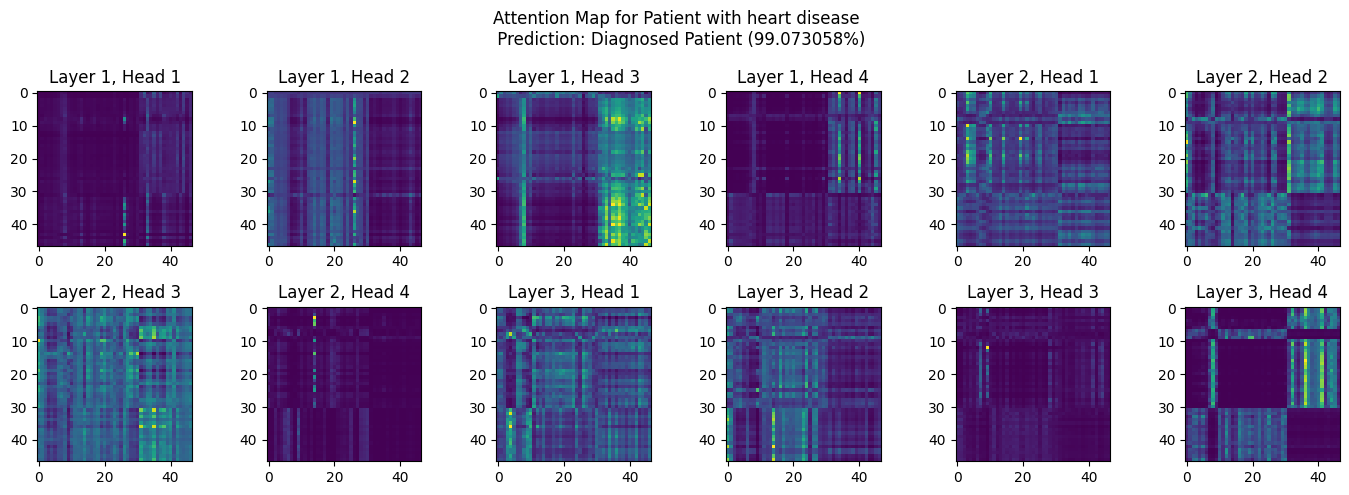

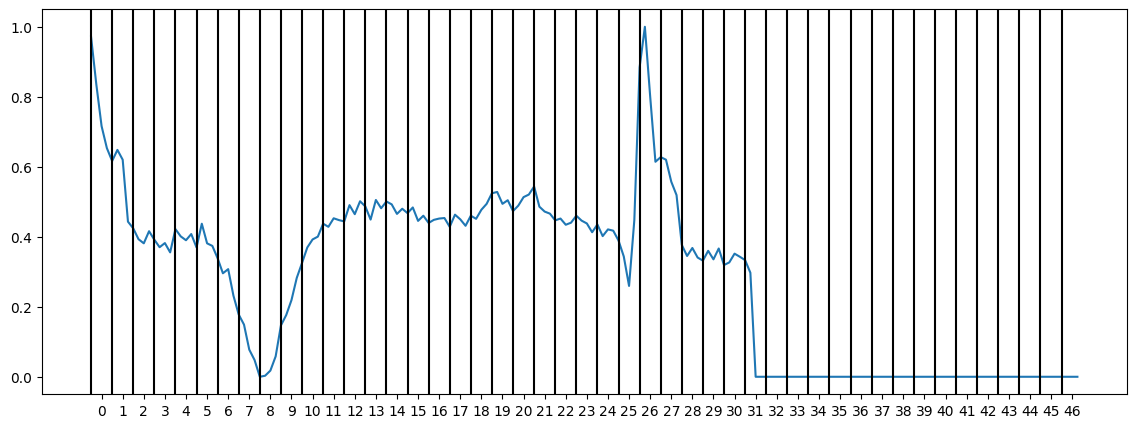

In [82]:
healthy_patients = X_test_tensor_transformer[(y_test_tensor == 0).squeeze(1), :,:]
diagnosed_patients = X_test_tensor_transformer[(y_test_tensor == 1).squeeze(1),:,:]

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    datapoint = None
    title = None

    if i < 2:
        datapoint = healthy_patients[i % 2,:,:].unsqueeze(0)
        title = 'Attention Map for Healthy patient'
    else:
        datapoint = diagnosed_patients[i % 2,:,:].unsqueeze(0)
        title = 'Attention Map for Patient with heart disease'

    pred, _ = transformer(datapoint)
    pred_label = None
    if pred.item() < 0.5:
        pred_label = "Healthy Patient"
    else:
        pred_label = "Diagnosed Patient"

    subtitle = f"Prediction: {pred_label} ({pred.item()*100:4f}%)"

    fig, axs = plt.subplots(int(total_heads/num_cols), num_cols, figsize=(14, 5))
    fig.suptitle(f"{title} \n {subtitle}")
    
    # Set x ticks in 3 equidistant positions
    self_attention_maps_logits, self_attention_maps_probs = extract_selfattention_maps(transformer.transformer_encoder, transformer.embed(datapoint))
    num_cols = 6
    total_heads = 12

    for i, attention_map in enumerate(self_attention_maps_probs):
        for j in range(4):
            index = int(i*4 + j)
            layout_index = index // num_cols, index % num_cols
            axs[layout_index].imshow(attention_map[0,j,:,:].detach().cpu().numpy())
            axs[layout_index].set_title(f'Layer {i + 1}, Head {j + 1}')
        
        plt.tight_layout()

    plt.show()

    fig = plt.figure(figsize=(14, 5))
    plt.plot(datapoint.view(-1).detach().cpu().numpy())

    window_size = 4

    map = self_attention_maps_probs[0][0,]

    for i in range(0, datapoint.shape[1] * window_size, window_size):
        plt.axvline(i, color='black')

    plt.xticks([i*window_size + 2 for i in range(datapoint.shape[1])], labels = [i for i in range(datapoint.shape[1])])

    plt.show()

